### MLP on Ecoli

In [25]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import keras as keras
import tensorflow as tf
from keras import initializers, regularizers
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from keras.optimizers.legacy import Adam
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
)
from scipy.stats import zscore
from sklearn.utils.class_weight import compute_class_weight

print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)
print("Scikeras version:",scikeras.__version__)

Tensorflow version: 2.13.0
Keras version: 2.13.1
Scikeras version: 0.11.0


In [2]:
ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_22072/608710242.py:1: DtypeWarning: Columns (530424) have mixed types. Specify dtype option on import or set low_memory=False.
  ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')


In [3]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [129]:
# Separate feature columns and target labels
X = ecoli.drop(columns=['TMP',"CTX","SUL","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
ecoli_tmp = X.copy()
ecoli_tmp['label'] = ecoli['TMP']
y_tmp = ecoli_tmp['label']

ecoli_ctx = X.copy()
ecoli_ctx['label'] = ecoli['CTX']
y_ctx = ecoli_ctx['label']

ecoli_sul = X.copy()
ecoli_sul['label'] = ecoli['SUL']
y_sul = ecoli_sul['label']

In [130]:
# Train-test split
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X, y_tmp, stratify= y_tmp, test_size=0.3, random_state=42)

X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X, y_ctx, stratify= y_ctx, test_size=0.3, random_state=42)

X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X, y_sul, stratify= y_sul, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_tmp, y_train_resampled_tmp = smote.fit_resample(X_train_tmp, y_train_tmp)
X_train_resampled_ctx, y_train_resampled_ctx = smote.fit_resample(X_train_ctx, y_train_ctx) 

print("TMP Resampled Class Distribution:", Counter(y_train_resampled_tmp))
print("CTX Resampled Class Distribution:", Counter(y_train_resampled_ctx))

TMP Resampled Class Distribution: Counter({0: 228, 1: 228})
CTX Resampled Class Distribution: Counter({1: 311, 0: 311})


In [131]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tmp = X_train_resampled_tmp['ST'].values
X_train_input_tmp = X_train_resampled_tmp.drop(columns=['ST'])
input_dim_tmp = X_train_input_tmp.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_sul = X_train_sul['ST'].values
X_train_input_sul = X_train_sul.drop(columns=['ST'])
input_dim_sul = X_train_input_sul.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_ctx = X_train_resampled_ctx['ST'].values
X_train_input_ctx = X_train_resampled_ctx.drop(columns=['ST'])
input_dim_ctx = X_train_input_ctx.shape[1]

### Blocked cross-validation

In [132]:
# Define parameter grid 
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001]
}


In [196]:
# Define model-building function
def create_model(learning_rate=0.0001, dropout_rate=0.2, layer1_size=20, input_dim=input_dim_tmp):
    model = Sequential()
    model.add(Dense(layer1_size, activation='relu', input_shape=(input_dim,),kernel_initializer=initializers.HeNormal(seed=seed_value), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate, seed=seed_value))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value)))
    model.compile(optimizer= Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  weighted_metrics=['accuracy'])
    return model

In [232]:
# Define model-building function
def create_model_tmp(learning_rate=0.001, input_dim=input_dim_tmp):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),kernel_initializer=initializers.HeNormal(seed=seed_value), kernel_regularizer=regularizers.l2(0.008)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3, seed=seed_value))
    model.add(Dense(64, activation='relu',kernel_initializer=initializers.HeNormal(seed=seed_value), kernel_regularizer=regularizers.l2(0.008)))
    # model.add(Dropout(0.3, seed=seed_value))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value),kernel_regularizer=regularizers.l2(0.008)))
    model.compile(optimizer= Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  weighted_metrics=['accuracy']
                  )
    return model

##### 1. TMP

In [19]:
model_tmp = KerasClassifier(model=create_model_tmp, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_tmp)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tmp, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tmp, y_train_resampled_tmp, groups=groups_tmp, verbose=0)
params_tmp = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-08 20:52:58.794746: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-08 20:52:58.794785: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-08 20:52:58.794796: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-08 20:52:58.794985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-08 20:52:58.795007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-08 20:53:00.679417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 20:53:43.341502:

Best Accuracy: 0.7114
Best Parameters: {'model__learning_rate': 0.0001}


##### 2. SUL

In [47]:
model_sul = KerasClassifier(model=create_model, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_sul)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_sul, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_sul, y_train_sul, groups=groups_sul, verbose=0)
params_sul = grid_result.best_params_
best_model_sul = grid_result.best_estimator_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-08 21:40:33.534072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:40:53.186083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:40:57.505633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:41:17.267665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:41:21.613562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:41:41.163764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 21:41:45.394932: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.6443
Best Parameters: {'model__learning_rate': 0.0001}


##### 3. CTX

In [48]:
model_ctx = KerasClassifier(model=create_model, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_ctx)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_ctx, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_ctx, y_train_resampled_ctx, groups=groups_ctx, verbose=0)
params_ctx = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-08 22:02:19.427164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:02:52.399601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:03:17.267079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:03:42.761428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:04:08.169783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:04:41.187414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-08 22:05:07.889874: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.7370
Best Parameters: {'model__learning_rate': 0.0001}


### Training with best hyperparameters and testing

In [218]:
def train_mlp_model(X_train, y_train, params, model):

    model = model(
        learning_rate=params['model__learning_rate'],
        input_dim=X_train.shape[1]
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )

    # Define class weights
    weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1,
        shuffle=True,
        #class_weight={0: weights[0], 1: weights[1]}, 
    )

    return model, history


In [136]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained model 
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction
    """
    # Predict probabilities
    y_test_prob = model.predict(X_test)
    y_train_prob = model.predict(X_train)

    # Flatten if needed (Keras outputs)
    if y_test_prob.ndim > 1:
        y_test_prob = y_test_prob.ravel()
    if y_train_prob.ndim > 1:
        y_train_prob = y_train_prob.ravel()

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    roc_auc = auc(*roc_curve(y_test, y_test_prob)[:2])

    # Classification report (per class)
    report = classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True)

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for MLP model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for MLP model of {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for MLP model of {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")
    
    print(report)


In [137]:
# Separate feature columns and target labels
X = ecoli.drop(columns=['TMP',"CTX","SUL","sample_ID", "ST"], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
ecoli_tmp = X.copy()
ecoli_tmp['label'] = ecoli['TMP']
y_tmp = ecoli_tmp['label']

ecoli_ctx = X.copy()
ecoli_ctx['label'] = ecoli['CTX']
y_ctx = ecoli_ctx['label']

ecoli_sul = X.copy()
ecoli_sul['label'] = ecoli['SUL']
y_sul = ecoli_sul['label']

# Train-test split
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X, y_tmp, stratify= y_tmp, test_size=0.3, random_state=42)

X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X, y_ctx, stratify= y_ctx, test_size=0.3, random_state=42)

X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X, y_sul, stratify= y_sul, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_tmp, y_train_resampled_tmp = smote.fit_resample(X_train_tmp, y_train_tmp)
X_train_resampled_ctx, y_train_resampled_ctx = smote.fit_resample(X_train_ctx, y_train_ctx) 

print("TMP Resampled Class Distribution:", Counter(y_train_resampled_tmp))
print("CTX Resampled Class Distribution:", Counter(y_train_resampled_ctx))
print("SUL Class Distribution:", Counter(y_train_sul))


TMP Resampled Class Distribution: Counter({0: 244, 1: 244})
CTX Resampled Class Distribution: Counter({0: 330, 1: 330})
SUL Class Distribution: Counter({0: 223, 1: 197})


##### 1. TMP

Epoch 1/100


2025-05-11 17:48:22.895104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.8594 - accuracy: 0.5604

2025-05-11 17:48:26.165004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 434ms/step - loss: 4.8594 - accuracy: 0.5604 - val_loss: 11.6561 - val_accuracy: 0.5918
Epoch 2/100
7/7 [==============================] - 1s 154ms/step - loss: 3.7331 - accuracy: 0.6697 - val_loss: 4.8538 - val_accuracy: 0.7959
Epoch 3/100
7/7 [==============================] - 1s 137ms/step - loss: 3.1343 - accuracy: 0.7244 - val_loss: 3.2126 - val_accuracy: 0.9184
Epoch 4/100
7/7 [==============================] - 1s 118ms/step - loss: 2.9294 - accuracy: 0.7585 - val_loss: 2.6486 - val_accuracy: 0.9388
Epoch 5/100
7/7 [==============================] - 1s 117ms/step - loss: 2.7243 - accuracy: 0.7585 - val_loss: 2.3469 - val_accuracy: 0.9388
Epoch 6/100
7/7 [==============================] - 1s 113ms/step - loss: 2.6365 - accuracy: 0.7768 - val_loss: 2.2480 - val_accuracy: 0.9388
Epoch 7/100
7/7 [==============================] - 1s 117ms/step - loss: 2.5095 - accuracy: 0.7882 - val_loss: 2.1961 - val_accuracy: 0.9388
Epoch 8/100
7/7 [=======

2025-05-11 17:49:42.082956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 23ms/step


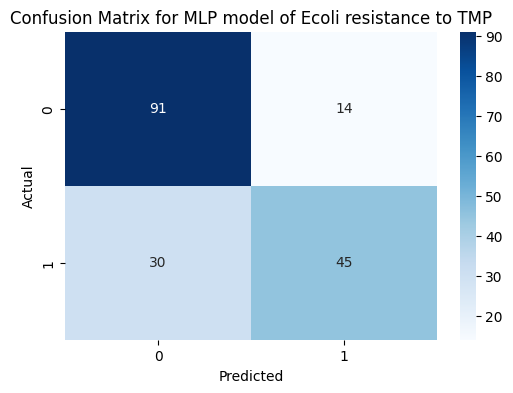

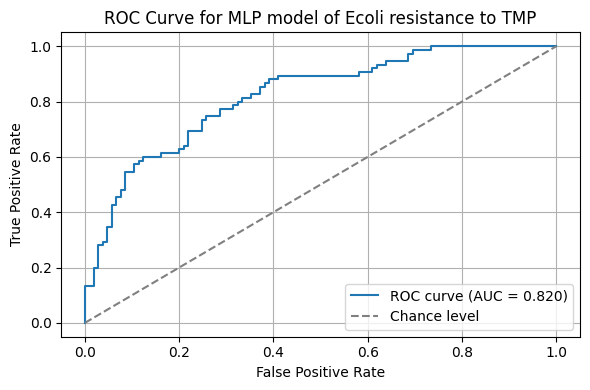

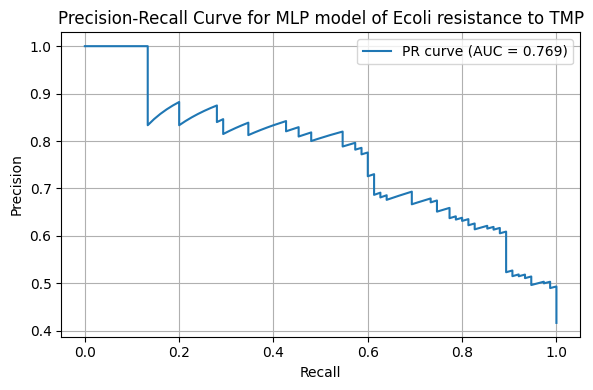

Training Accuracy: 0.9447
Test Accuracy:     0.7556
Overall Precision: 0.7627
Overall Recall:    0.6000
Overall F1 Score:  0.6716
ROC AUC:           0.8198

Per-Class Performance:
Susceptible  | Precision: 0.75 | Recall: 0.87 | F1: 0.81
Resistant    | Precision: 0.76 | Recall: 0.60 | F1: 0.67
{'Susceptible': {'precision': 0.7520661157024794, 'recall': 0.8666666666666667, 'f1-score': 0.8053097345132745, 'support': 105.0}, 'Resistant': {'precision': 0.7627118644067796, 'recall': 0.6, 'f1-score': 0.6716417910447762, 'support': 75.0}, 'accuracy': 0.7555555555555555, 'macro avg': {'precision': 0.7573889900546296, 'recall': 0.7333333333333334, 'f1-score': 0.7384757627790253, 'support': 180.0}, 'weighted avg': {'precision': 0.7565018443292711, 'recall': 0.7555555555555555, 'f1-score': 0.7496147580680669, 'support': 180.0}}


In [233]:
mlp_tmp, _ = train_mlp_model(X_train_resampled_tmp, y_train_resampled_tmp, params_tmp, create_model_tmp)
evaluate_model(mlp_tmp, X_train_resampled_tmp, y_train_resampled_tmp, X_test_tmp, y_test_tmp, threshold=0.5, model_name="Ecoli resistance to TMP")

##### 2. SUL

Epoch 1/100


2025-05-11 16:21:08.118765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 159ms/step - loss: 2.6694 - accuracy: 0.5686 - val_loss: 2.2709 - val_accuracy: 0.6429
Epoch 2/100


2025-05-11 16:21:10.145034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 73ms/step - loss: 2.6020 - accuracy: 0.6618 - val_loss: 1.5029 - val_accuracy: 0.7143
Epoch 3/100
6/6 [==============================] - 0s 71ms/step - loss: 2.4638 - accuracy: 0.7017 - val_loss: 1.0075 - val_accuracy: 0.7619
Epoch 4/100
6/6 [==============================] - 0s 65ms/step - loss: 2.3411 - accuracy: 0.7181 - val_loss: 1.2237 - val_accuracy: 0.7143
Epoch 5/100
6/6 [==============================] - 0s 68ms/step - loss: 2.2794 - accuracy: 0.7176 - val_loss: 1.1057 - val_accuracy: 0.7381
Epoch 6/100
6/6 [==============================] - 0s 66ms/step - loss: 2.1231 - accuracy: 0.7465 - val_loss: 1.1916 - val_accuracy: 0.7619
Epoch 7/100
6/6 [==============================] - 0s 67ms/step - loss: 1.9987 - accuracy: 0.7701 - val_loss: 1.1256 - val_accuracy: 0.8095
Epoch 8/100
6/6 [==============================] - 0s 68ms/step - loss: 1.9505 - accuracy: 0.7743 - val_loss: 1.1473 - val_accuracy: 0.7619
Epoch 9/100
6/6 [===============

2025-05-11 16:21:27.338375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 13ms/step


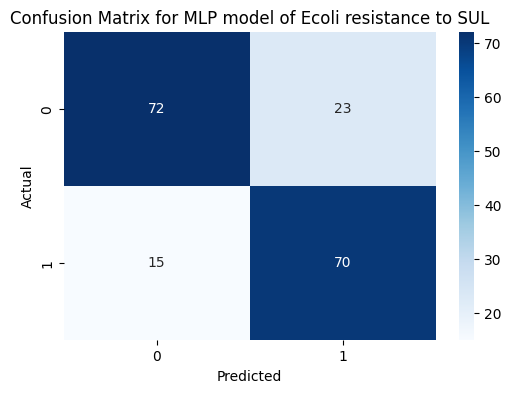

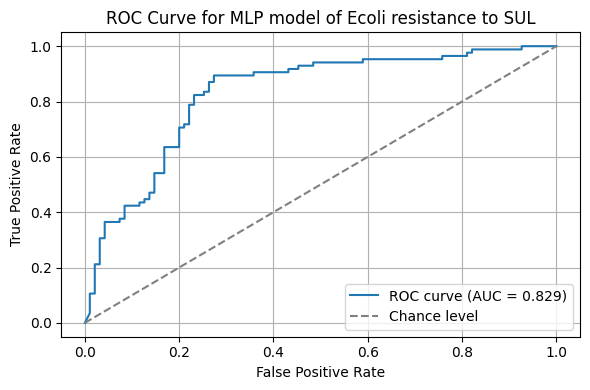

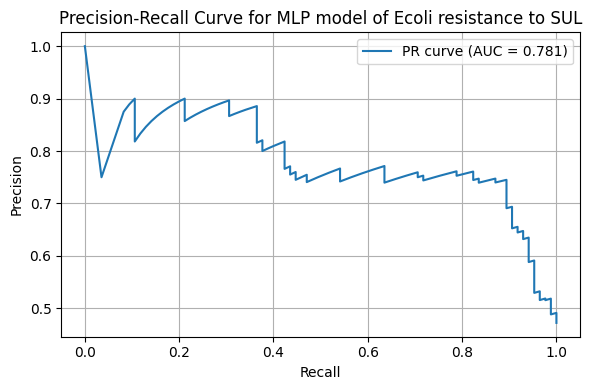

Training Accuracy: 0.8643
Test Accuracy:     0.7889
Overall Precision: 0.7527
Overall Recall:    0.8235
Overall F1 Score:  0.7865
ROC AUC:           0.8289

Per-Class Performance:
Susceptible  | Precision: 0.83 | Recall: 0.76 | F1: 0.79
Resistant    | Precision: 0.75 | Recall: 0.82 | F1: 0.79
{'Susceptible': {'precision': 0.8275862068965517, 'recall': 0.7578947368421053, 'f1-score': 0.7912087912087912, 'support': 95.0}, 'Resistant': {'precision': 0.7526881720430108, 'recall': 0.8235294117647058, 'f1-score': 0.7865168539325843, 'support': 85.0}, 'accuracy': 0.7888888888888889, 'macro avg': {'precision': 0.7901371894697813, 'recall': 0.7907120743034055, 'f1-score': 0.7888628225706877, 'support': 180.0}, 'weighted avg': {'precision': 0.7922176904379351, 'recall': 0.7888888888888889, 'f1-score': 0.7889931541616935, 'support': 180.0}}


In [138]:
mlp_sul, _ = train_mlp_model(X_train_sul, y_train_sul, params_sul, create_model)
evaluate_model(mlp_sul, X_train_sul, y_train_sul, X_test_sul, y_test_sul, threshold=0.5, model_name="Ecoli resistance to SUL")

##### 3. CTX

Epoch 1/100


2025-05-11 17:50:52.101902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 321ms/step - loss: 2.8088 - accuracy: 0.6717 - val_loss: 2.0307 - val_accuracy: 0.8030


2025-05-11 17:50:55.510865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
10/10 [==============================] - 1s 109ms/step - loss: 2.0522 - accuracy: 0.8418 - val_loss: 1.8191 - val_accuracy: 0.8030
Epoch 3/100
10/10 [==============================] - 1s 82ms/step - loss: 1.7929 - accuracy: 0.8502 - val_loss: 2.0071 - val_accuracy: 0.7879
Epoch 4/100
10/10 [==============================] - 1s 78ms/step - loss: 1.6076 - accuracy: 0.8485 - val_loss: 1.3681 - val_accuracy: 0.8333
Epoch 5/100
10/10 [==============================] - 1s 78ms/step - loss: 1.5824 - accuracy: 0.8401 - val_loss: 0.9250 - val_accuracy: 0.8333
Epoch 6/100
10/10 [==============================] - 1s 83ms/step - loss: 1.5345 - accuracy: 0.8569 - val_loss: 1.1018 - val_accuracy: 0.8333
Epoch 7/100
10/10 [==============================] - 1s 81ms/step - loss: 1.1824 - accuracy: 0.8704 - val_loss: 0.8954 - val_accuracy: 0.8333
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 1.3917 - accuracy: 0.8721 - val_loss: 0.7110 - val_accuracy: 0.8485
Epoch

2025-05-11 17:52:10.985635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 21ms/step


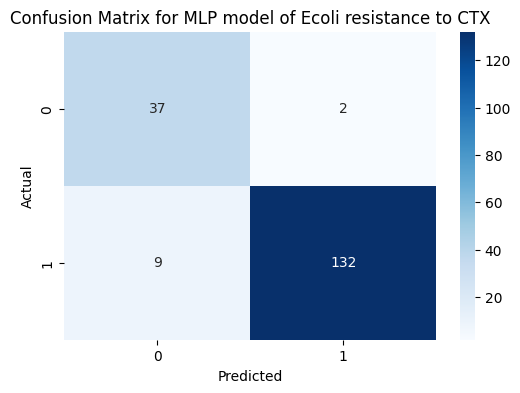

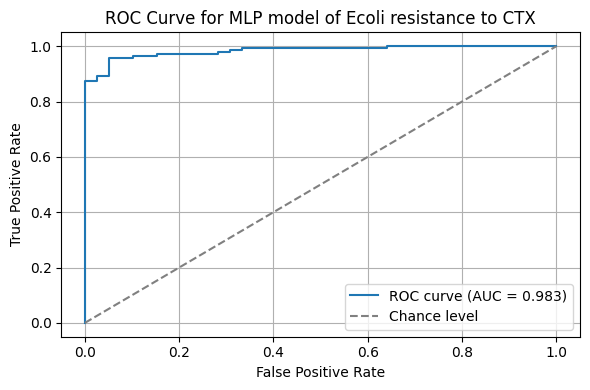

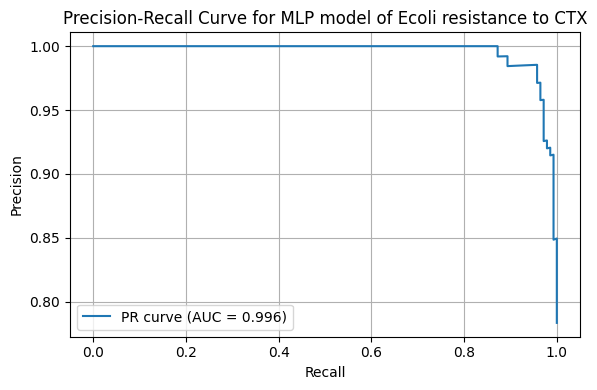

Training Accuracy: 0.9864
Test Accuracy:     0.9389
Overall Precision: 0.9851
Overall Recall:    0.9362
Overall F1 Score:  0.9600
ROC AUC:           0.9833

Per-Class Performance:
Susceptible  | Precision: 0.80 | Recall: 0.95 | F1: 0.87
Resistant    | Precision: 0.99 | Recall: 0.94 | F1: 0.96
{'Susceptible': {'precision': 0.8043478260869565, 'recall': 0.9487179487179487, 'f1-score': 0.8705882352941177, 'support': 39.0}, 'Resistant': {'precision': 0.9850746268656716, 'recall': 0.9361702127659575, 'f1-score': 0.96, 'support': 141.0}, 'accuracy': 0.9388888888888889, 'macro avg': {'precision': 0.8947112264763141, 'recall': 0.9424440807419531, 'f1-score': 0.9152941176470588, 'support': 180.0}, 'weighted avg': {'precision': 0.9459171533636167, 'recall': 0.9388888888888889, 'f1-score': 0.9406274509803921, 'support': 180.0}}


In [234]:
mlp_ctx, _ = train_mlp_model(X_train_resampled_ctx, y_train_resampled_ctx, params_ctx, create_model)
evaluate_model(mlp_ctx, X_train_resampled_ctx, y_train_resampled_ctx, X_test_ctx, y_test_ctx, threshold=0.5, model_name="Ecoli resistance to CTX")

### Feature importance

In [235]:
def get_top_outliers(model, X_train):
    # get the weights of all layers
    weights = [layer.get_weights()[0] for layer in model.layers if isinstance(layer, keras.layers.Dense)]

    # Flatten the weights into a single vector
    flattened_weights = np.concatenate([w.flatten() for w in weights])

    # Compute Z-scores for the flattened weights
    z_scores = zscore(flattened_weights)

    # Identify outliers (e.g., Z-score > 3 or Z-score < -3 are considered outliers)
    outliers = np.where(np.abs(z_scores) > 3)[0]  # Indices of outliers
    print("Outlier indices based on Z-scores:", outliers)

    # Get the absolute values of the outlier weights
    outlier_weights = np.abs(flattened_weights[outliers])

    # Rank the outliers based on their absolute weight values (highest first)
    top_20_outlier_indices = outliers[np.argsort(outlier_weights)[-20:][::-1]]

    print("Top 20 outlier indices:", top_20_outlier_indices)

    # For the first layer, map outlier indices to input features
    first_layer_weights = weights[0]  # The weights of the first layer

    # Map the top 20 outlier indices to input feature indices
    input_feature_indices = top_20_outlier_indices % first_layer_weights.shape[0]

    print("Top 20 outlier features (input feature indices):", input_feature_indices)

    # Display the top 20 outlier features and their corresponding weights
    top_20_outlier_weights = flattened_weights[top_20_outlier_indices]
    print("Top 20 Outlier Features and Their Corresponding Weights:")
    for i, idx in enumerate(top_20_outlier_indices):
        print(f"Feature {input_feature_indices[i]}: Weight = {top_20_outlier_weights[i]}")


    # Get the column names (feature names)
    feature_names = X_train.columns

    # Map the top 20 outlier indices to the corresponding feature names
    top_20_feature_names = feature_names[input_feature_indices]  # input_feature_indices is from previous steps

    print("Top 20 outlier feature names:", top_20_feature_names)

    return top_20_feature_names, top_20_outlier_weights




In [236]:
def visualize_outliers(top_20_feature_names, top_20_outlier_weights, drug_name):

    # Set figure size for better readability
    plt.figure(figsize=(14, 7))

    # Separate positive and negative weights
    positive_weights = top_20_outlier_weights[top_20_outlier_weights > 0]
    negative_weights = top_20_outlier_weights[top_20_outlier_weights < 0]

    # Define color maps for positive (red) and negative (blue) weights
    positive_colors = plt.cm.Reds(np.linspace(0, 1, len(positive_weights)))  # Reds for positive weights
    negative_colors = plt.cm.Blues(np.linspace(0, 1, len(negative_weights)))  # Blues for negative weights

    # Plot bars for positive and negative weights
    bars_positive = plt.barh(range(len(positive_weights)), positive_weights, color=positive_colors)
    bars_negative = plt.barh(range(len(positive_weights), len(positive_weights) + len(negative_weights)), 
                            negative_weights, color=negative_colors)

    # Add feature names as y-ticks for both positive and negative bars
    plt.yticks(range(len(top_20_feature_names)), top_20_feature_names, fontsize=10)

    # Add titles and labels with a larger font size
    plt.title('Top 20 Outlier Features\n(MLP - Ecoli Resistance to {})'.format(drug_name))
    plt.xlabel('Outlier Weight Value', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)

    # Optionally, add gridlines to make it easier to read the x-values
    plt.grid(axis='x', linestyle='--', alpha=0.7)


    # Adjust layout to ensure everything fits properly
    plt.tight_layout()

    # Show the plot
    plt.show()


##### 1. TMP

Outlier indices based on Z-scores: [  297998   303246   303374 ... 67902013 67902014 67902015]
Top 20 outlier indices: [67902015 67901991 67901999 67894659 67901989 67902001 67901955 67901961
 67898004 67899145 67901972 67902004 67900297 67896585 67901833 67895269
 67895345 67894669 67897056 67898535]
Top 20 outlier features (input feature indices): [8255 8231 8239  899 8229 8241 8195 8201 4244 5385 8212 8244 6537 2825
 8073 1509 1585  909 3296 4775]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 8255: Weight = 0.29663708806037903
Feature 8231: Weight = -0.2962922751903534
Feature 8239: Weight = -0.2935276925563812
Feature 899: Weight = -0.29323339462280273
Feature 8229: Weight = 0.28906139731407166
Feature 8241: Weight = -0.2886562645435333
Feature 8195: Weight = -0.2860337197780609
Feature 8201: Weight = -0.2827345132827759
Feature 4244: Weight = -0.28158530592918396
Feature 5385: Weight = 0.2807515561580658
Feature 8212: Weight = -0.273226797580719
Feature 8244: We

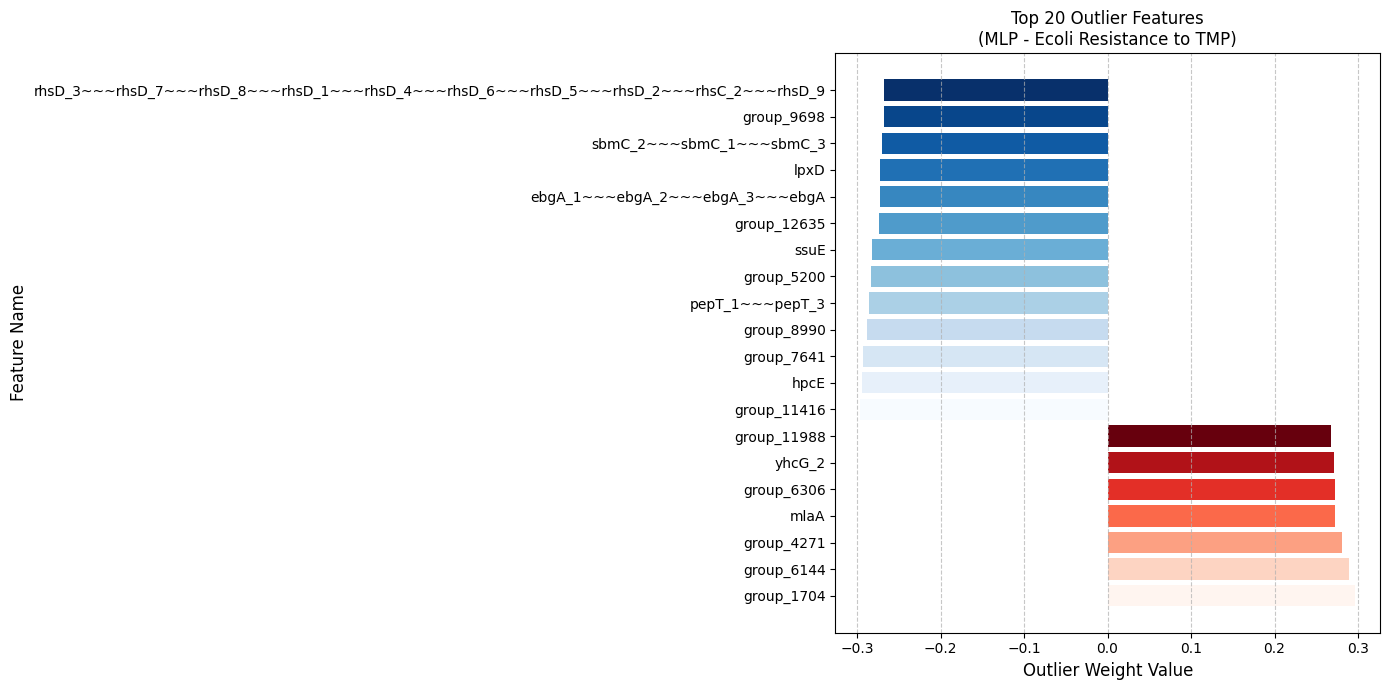

In [237]:
feature_names_tmp, outlier_weights_tmp = get_top_outliers(mlp_tmp, X_train_resampled_tmp)
visualize_outliers(feature_names_tmp, outlier_weights_tmp, drug_name="TMP")

##### 2. SUL

Outlier indices based on Z-scores: [      27       67      123 ... 10608416 10608417 10608419]
Top 20 outlier indices: [10608403 10608409 10608410 10608404 10608408 10608407 10608417 10608419
 10608411 10608415 10608406 10608413 10608414 10608400 10608402 10608405
 10608416 10608412  7015951   112663]
Top 20 outlier features (input feature indices): [     3      9     10      4      8      7     17     19     11     15
      6     13     14      0      2      5     16     12 120491 112663]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.5161271095275879
Feature 9: Weight = -0.4755233824253082
Feature 10: Weight = 0.46160805225372314
Feature 4: Weight = -0.45100605487823486
Feature 8: Weight = -0.400749534368515
Feature 7: Weight = -0.35293373465538025
Feature 17: Weight = -0.35166436433792114
Feature 19: Weight = -0.31952962279319763
Feature 11: Weight = -0.2911969721317291
Feature 15: Weight = 0.28189393877983093
Feature 6: Weight = 0.2659503221511841
F

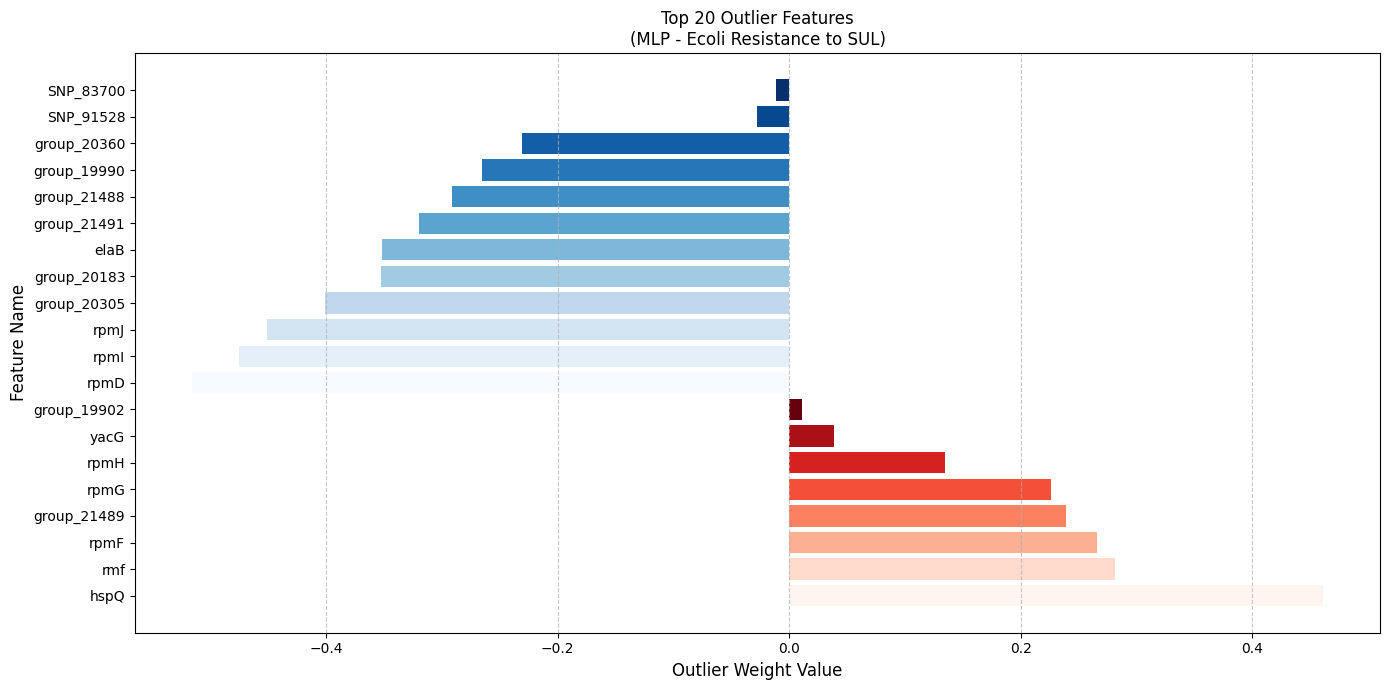

In [238]:
feature_names_sul, outlier_weights_sul = get_top_outliers(mlp_sul, X_train_sul)
visualize_outliers(feature_names_sul, outlier_weights_sul, drug_name="SUL")

##### 3. CTX

Outlier indices based on Z-scores: [      28       48       67 ... 10608416 10608417 10608419]
Top 20 outlier indices: [10608403 10608409 10608404 10608408 10608410 10608407 10608417 10608419
 10608411 10608413 10608415 10608406 10608400 10608414 10608402 10608405
    83507 10608412   113287    96047]
Top 20 outlier features (input feature indices): [     3      9      4      8     10      7     17     19     11     13
     15      6      0     14      2      5  83507     12 113287  96047]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.5175788402557373
Feature 9: Weight = -0.4790687561035156
Feature 4: Weight = -0.46281465888023376
Feature 8: Weight = -0.43078237771987915
Feature 10: Weight = 0.40598782896995544
Feature 7: Weight = -0.3880558907985687
Feature 17: Weight = -0.3528512418270111
Feature 19: Weight = -0.32572224736213684
Feature 11: Weight = -0.3016699254512787
Feature 13: Weight = -0.2797381281852722
Feature 15: Weight = 0.26168957352638245

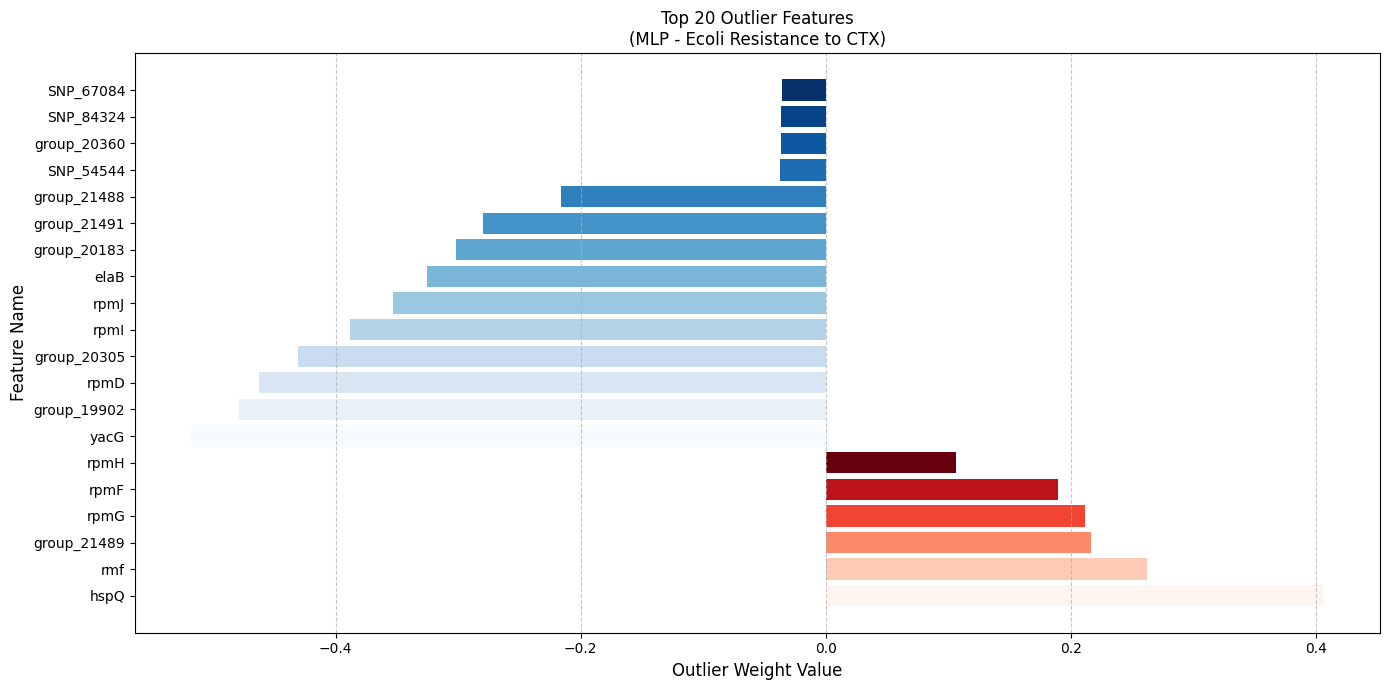

In [239]:
feature_names_ctx, outlier_weights_ctx = get_top_outliers(mlp_ctx, X_train_resampled_ctx)
visualize_outliers(feature_names_ctx, outlier_weights_ctx, drug_name="CTX")